## **Import Library**

Mengimpor semua pustaka yang dibutuhkan untuk proyek sistem rekomendasi ini.

Pustaka-pustaka ini dikelompokkan berdasarkan fungsinya:
-   **Analisis Data:** `pandas` dan `numpy` untuk memuat dan memanipulasi data.
-   **Visualisasi:** `matplotlib` dan `seaborn` untuk membuat plot dan memahami data secara visual.
-   **Pemrosesan Teks (Content-Based):**
    -   `TfidfVectorizer` dan `cosine_similarity` dari Scikit-learn untuk mengubah teks menjadi angka dan menghitung kemiripan antar item.
    -   `Sastrawi` untuk melakukan *stopword removal* (membuang kata umum) dan *stemming* (mengubah kata ke bentuk dasarnya) pada teks Bahasa Indonesia.
-   **Modeling (Collaborative Filtering):**
    -   `tensorflow` dan `keras` untuk membangun dan melatih model *deep learning*.
-   **Penyimpanan & Utilitas:** `os`, `pickle`, dan `joblib` untuk manajemen file dan penyimpanan model.

In [1]:
# Library untuk analisis dan manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Library untuk pemrosesan teks (Content-Based Filtering)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Library Sastrawi untuk pemrosesan teks Bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Library untuk Collaborative Filtering dengan Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Library untuk utilitas lain dan display tabel
from IPython.display import display # Untuk menampilkan DataFrame dengan border
import pickle # Untuk menyimpan model/objek Python
import os # Untuk operasi sistem seperti membuat direktori
import warnings
warnings.filterwarnings('ignore') # Mengabaikan pesan warning untuk output lebih bersih
print("Semua library yang dibutuhkan telah di-import.")


Semua library yang dibutuhkan telah di-import.


**Hasil dan Insight:**

Semua library yang dibutuhkan telah di-import.

## **Definisi Fungsi dan Kelas**

### Inisialisasi Variabel Global

Pada tahap ini, kita menginisialisasi beberapa variabel "global" yang akan digunakan di seluruh notebook untuk menyimpan hasil dan melacak status proses. 

Variabel-variabel tersebut adalah:
-   `results`: Sebuah *dictionary* kosong untuk menyimpan hasil evaluasi.
-   `MODEL_CF_SUCCESS` & `MODEL_CBF_SUCCESS`: Dua buah *boolean flag* yang awalnya diatur ke `False`. Ini akan berubah menjadi `True` jika model terkait berhasil dilatih.
-   `top_5_recs...`: Dua DataFrame kosong untuk menampung daftar rekomendasi yang akan dihasilkan nanti.

In [2]:
# Variabel untuk menyimpan hasil dan status model
results = {}
MODEL_CF_SUCCESS = False
MODEL_CBF_SUCCESS = False

# DataFrame untuk menyimpan hasil rekomendasi
top_5_recs_cbf = pd.DataFrame()
top_5_recs_cf_keras = pd.DataFrame()

print("Variabel global telah diinisialisasi.")

Variabel global telah diinisialisasi.


**Hasil dan Insight:**
-   Semua variabel yang didefinisikan sekarang ada di memori dan siap untuk diisi pada langkah-langkah berikutnya.
-   Penggunaan *flag* seperti `MODEL_CF_SUCCESS` sangat berguna. Ini memungkinkan kita untuk menjalankan langkah-langkah selanjutnya secara kondisional. Contohnya, kita hanya akan menyimpan model jika *flag* ini bernilai `True`, yang menandakan proses pelatihan sebelumnya berhasil tanpa error.

### Fungsi untuk Preprocessing Teks (Sastrawi)

Pada cell ini, kita mendefinisikan sebuah fungsi bernama `preprocess_text_sastrawi`. Fungsi ini dirancang khusus untuk membersihkan dan menstandarisasi teks dalam Bahasa Indonesia dengan melakukan tiga langkah utama:
1.  **Lowercase:** Mengubah semua huruf dalam teks menjadi huruf kecil agar konsisten.
2.  **Stemming:** Menggunakan *stemmer* dari pustaka `Sastrawi` untuk mengubah setiap kata ke bentuk dasarnya (misalnya, "permandian" menjadi "mandi").
3.  **Stopword Removal:** Menggunakan *stopword remover* dari `Sastrawi` untuk menghapus kata-kata umum yang tidak memiliki makna signifikan (seperti "dan", "yang", "di", "ke", dll.).

In [3]:
def preprocess_text_sastrawi(text, stemmer, stopword_remover):
    if pd.isna(text) or text.strip() == '': return ''
    text = text.lower()
    text_stemmed = stemmer.stem(text)
    text_cleaned = stopword_remover.remove(text_stemmed)
    return text_cleaned

print("Fungsi untuk Pricessing telah berhasil didefinisikan")

Fungsi untuk Pricessing telah berhasil didefinisikan


**Hasil dan Insight:**
-   Fungsi `preprocess_text_sastrawi` telah tersedia di memori dan siap digunakan untuk memproses seluruh data teks kita pada langkah berikutnya.
-   Dengan melakukan stemming dan stopword removal, kita secara efektif mengurangi jumlah kata unik (kosakata) dan mengelompokkan kata-kata yang serupa. Ini akan membuat proses analisis kemiripan antar tempat di tahap selanjutnya menjadi jauh lebih akurat dan relevan secara makna.

### Kelas Model Collaborative Filtering (RecommenderNet)

Pada cell ini, kita mendefinisikan arsitektur lengkap dari model **Collaborative Filtering** berbasis *deep learning* menggunakan Keras. Model ini adalah implementasi dari **Matrix Factorization dengan Biases**. Komponen utamanya adalah:
1.  **User & Place Embedding:** Layer yang mempelajari vektor fitur laten (selera pengguna dan karakteristik tempat).
2.  **User & Place Bias:** Layer khusus yang mempelajari bias atau kecenderungan intrinsik dari setiap pengguna (misalnya, ada pengguna yang cenderung memberi rating tinggi) dan setiap tempat (misalnya, ada tempat yang cenderung populer).
3.  **Metode `call`:** Mendefinisikan alur prediksi, yaitu: `Prediksi = (User Embedding · Place Embedding) + User Bias + Place Bias`.

In [4]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(num_places, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.place_bias = layers.Embedding(num_places, 1)
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias_vec = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias_vec = self.place_bias(inputs[:, 1])
        dot_user_place = tf.tensordot(user_vector, place_vector, 2)
        x = dot_user_place + user_bias_vec + place_bias_vec
        return tf.nn.sigmoid(x)

print("Kelas RecommenderNet telah berhasil didefinisikan")

Kelas RecommenderNet telah berhasil didefinisikan


**Hasil dan Insight:**
-   Penggunaan *bias* adalah teknik canggih yang membuat model lebih kuat daripada sekadar *dot product* biasa.
-   Output model menggunakan aktivasi **sigmoid**, yang berarti model ini dirancang untuk memprediksi rating yang telah dinormalisasi ke dalam rentang **0 hingga 1**.

### Fungsi untuk Mendapatkan Rekomendasi

Pada cell ini mendefinisikan dua fungsi "pembantu" yang akan menjadi antarmuka akhir untuk mendapatkan hasil rekomendasi dari masing-masing model.
1.  **`get_content_based_recommendations`:** Fungsi ini mengambil sebuah ID tempat, lalu menggunakan matriks *cosine similarity* yang sudah dihitung sebelumnya untuk menemukan dan mengembalikan N tempat lain yang paling mirip berdasarkan kontennya.
2.  **`get_top_n_recommendations_keras_cf`:** Fungsi ini mengambil sebuah ID pengguna, kemudian:
    -   Mengidentifikasi semua tempat yang **belum** pernah dikunjungi/dirating oleh pengguna tersebut.
    -   Menggunakan model Keras (`RecommenderNet`) yang sudah dilatih untuk **memprediksi rating** pengguna untuk semua tempat tersebut.
    -   Mengurutkan hasil prediksi dari yang tertinggi dan mengembalikan N tempat teratas.

In [5]:
def get_content_based_recommendations(place_id_ref, n=5, cosine_sim_matrix_param=None, tourism_df_param=None, id_to_idx_map_param=None):
    if cosine_sim_matrix_param is None or tourism_df_param is None or id_to_idx_map_param is None:
        return "Model CBF belum siap."
    if place_id_ref not in id_to_idx_map_param:
        place_name_matches = tourism_df_param[tourism_df_param['Place_Name'] == place_id_ref]
        if not place_name_matches.empty:
            place_id_ref_from_name = place_name_matches['Place_Id'].iloc[0]
            if place_id_ref_from_name in id_to_idx_map_param: idx = id_to_idx_map_param[place_id_ref_from_name]
            else: return f"ID Tempat (dari nama) '{place_id_ref_from_name}' tidak ditemukan di map."
        else: return f"ID Tempat atau Nama '{place_id_ref}' tidak ditemukan."
    else: idx = id_to_idx_map_param[place_id_ref]    
    sim_scores = list(enumerate(cosine_sim_matrix_param[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
    place_indices = [i[0] for i in sim_scores]
    recommendations_df = tourism_df_param.iloc[place_indices][['Place_Id', 'Place_Name', 'Category', 'Rating']].copy()
    recommendations_df['similarity_score'] = [s[1] for s in sim_scores]
    return recommendations_df

def get_top_n_recommendations_keras_cf(user_real_id, n=5, model=None, tourism_df_all_yogya=None, rating_df_yogya_cf=None, mappings=None):
    if model is None or mappings is None:
        return "Model CF belum siap."
    user_to_user_encoded_cf = mappings['user_to_user_encoded']
    place_to_place_encoded_cf = mappings['place_to_place_encoded']
    place_encoded_to_place_cf = mappings['place_encoded_to_place']
    
    user_enc = user_to_user_encoded_cf.get(user_real_id)
    if user_enc is None: return "User ID tidak ditemukan dalam data training CF."
    all_place_ids_yogya = tourism_df_all_yogya['Place_Id'].unique()
    place_ids_in_cf_model_list = list(place_to_place_encoded_cf.keys())
    rated_items_by_user = rating_df_yogya_cf[rating_df_yogya_cf['User_Id'] == user_real_id]['Place_Id'].unique()
    candidate_items_for_prediction = [pid for pid in all_place_ids_yogya if pid in place_ids_in_cf_model_list and pid not in rated_items_by_user]
    if not candidate_items_for_prediction: return pd.DataFrame(columns=['Place_Id', 'Place_Name', 'Category', 'Rating', 'Predicted_Normalized_Rating'])
    place_encoded_candidates = [place_to_place_encoded_cf[pid] for pid in candidate_items_for_prediction]
    user_place_array = np.array([[user_enc, place_enc] for place_enc in place_encoded_candidates])
    predictions_normalized = model.predict(user_place_array, verbose=0).flatten()
    top_indices = predictions_normalized.argsort()[-n:][::-1]
    recommended_original_place_ids = [place_encoded_to_place_cf[place_encoded_candidates[i]] for i in top_indices]
    recommendations_df = tourism_df_all_yogya[tourism_df_all_yogya['Place_Id'].isin(recommended_original_place_ids)][['Place_Id', 'Place_Name', 'Category', 'Rating']].copy()
    pred_map = {place_encoded_to_place_cf[place_encoded_candidates[i]]: predictions_normalized[i] for i in top_indices}
    recommendations_df['Predicted_Normalized_Rating'] = recommendations_df['Place_Id'].map(pred_map)
    return recommendations_df.sort_values('Predicted_Normalized_Rating', ascending=False)

print("Fungsi untuk Mendapatkan Rekomendasi telah berhasil didefinisikan.")

Fungsi untuk Mendapatkan Rekomendasi telah berhasil didefinisikan.


**Hasil dan Insight:**
- Kedua fungsi ini sekarang telah didefinisikan dan siap digunakan setelah model-model yang bersangkutan (matriks similarity untuk CBF dan model Keras untuk CF) selesai dibuat dan dilatih.

## **Data Understanding**

### Memuat Dataset

In [6]:
# Memuat Dataset
df_tourism_raw = pd.read_csv('dataset/tourism_with_id.csv')
df_rating_raw = pd.read_csv('dataset/tourism_rating.csv')
df_user_raw = pd.read_csv('dataset/user.csv')
print("\nFile CSV berhasil dimuat dari folder 'dataset/'.")


File CSV berhasil dimuat dari folder 'dataset/'.


### Membuat Salinan

In [7]:
# Membuat salinan untuk diproses agar data mentah tetap ada jika diperlukan
df_tourism = df_tourism_raw.copy()
df_rating = df_rating_raw.copy()
df_user = df_user_raw.copy()
print("\nDataFrame berhasil dicopy untuk mengantisipasi data oroginal masih tersimpan rapi.")


DataFrame berhasil dicopy untuk mengantisipasi data oroginal masih tersimpan rapi.


### Informasi Umum dan Variabel Dataset

Pada tahap ini, kita melakukan analisis eksplorasi data (EDA) yang komprehensif pada dataset untuk memahami secara mendalam struktur, konten, dan kualitas data. Insight dari sini akan menjadi dasar untuk langkah pembersihan data dan rekayasa fitur selanjutnya. Kita menggunakan beberapa fungsi sekaligus untuk mendapatkan gambaran menyeluruh:
-   `.info()` untuk ringkasan teknis.
-   `.head()` dan `.tail()` untuk melihat sampel data secara kualitatif.
-   `.describe()` untuk statistik pada kolom numerik penting.
-   `.isnull().sum()` untuk menghitung nilai kosong secara presisi.

#### `df_tourism` (Tempat Wisata)

In [8]:
print("Info Detail Variabel (df_tourism):")
df_tourism.info()

print("\nContoh Data Awal (df_tourism):")
display(df_tourism.head(3))

print("Contoh Data Akhir (df_tourism):")
display(df_tourism.tail(3))

print("Statistik Deskriptif Harga (Price) dan Rating Publik (Rating) pada df_tourism:")
display(df_tourism[['Price', 'Rating']].describe())

print("Cek nilai null di df_tourism:")
display(df_tourism.isnull().sum().to_frame(name='jumlah_null'))

Info Detail Variabel (df_tourism):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB

Contoh Data Awal (df_tourism):


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3


Contoh Data Akhir (df_tourism):


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436
436,437,Gereja Perawan Maria Tak Berdosa Surabaya,Gereja Katolik Kelahiran Santa Perawan Maria m...,Tempat Ibadah,Surabaya,10000,4.8,NaN,"{'lat': -7.2420758, 'lng': 112.7368158}",-7.242076,112.736816,NaN,437


Statistik Deskriptif Harga (Price) dan Rating Publik (Rating) pada df_tourism:


,Price,Rating
count,437.000000,437.000000
mean,24652.173913,4.442792
std,66446.374709,0.208587
min,0.000000,3.400000
25%,0.000000,4.300000
50%,5000.000000,4.500000
75%,20000.000000,4.600000
max,900000.000000,5.000000


Cek nilai null di df_tourism:


,jumlah_null
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


**Hasil dan Insight:**

-   **Struktur Data:**
    -   Dataset ini berisi **437 tempat wisata** dengan **13 kolom fitur**.
    -   Kolom-kolom utama seperti `Place_Name`, `Description`, dan `Category` tampaknya lengkap dan akan sangat berguna untuk model *Content-Based Filtering*.

-   **Kualitas Data & Missing Values:**
    -   **Kolom `Unnamed: 11` dan `Unnamed: 12`** terlihat seperti artefak atau sisa dari proses impor data. `Unnamed: 11` kosong sepenuhnya, sementara `Unnamed: 12` tampaknya duplikat dari `Place_Id`. Kedua kolom ini adalah kandidat kuat untuk **dihapus**.
    -   Kolom **`Time_Minutes` memiliki 232 nilai kosong**, yang berarti lebih dari separuh data durasi kunjungan tidak tersedia. Jika fitur ini ingin digunakan, kita memerlukan strategi penanganan *missing value* yang jelas (misalnya, diisi dengan median atau dihapus).

-   **Statistik & Distribusi:**
    -   **Rating:** Rata-rata rating adalah **4.44**, yang sangat tinggi. Nilai minimumnya adalah **3.4**. Ini adalah insight yang sangat penting: dataset ini **tidak memiliki rating rendah** (1, 2, atau awal 3). Ini menandakan adanya *positive selection bias*, di mana data yang kita miliki cenderung berasal dari pengalaman yang positif.
    -   **Price:** Terdapat rentang harga yang sangat lebar, dari **0 (gratis) hingga 900,000**. Standar deviasi yang sangat besar (66,446) dibandingkan dengan rata-ratanya (24,652) mengonfirmasi adanya beberapa tempat dengan harga tiket sangat mahal yang berperan sebagai *outlier*.

- Data tempat wisata ini memiliki kualitas yang baik untuk fitur-fitur utamanya. Langkah selanjutnya yang perlu dilakukan adalah **pembersihan data**, yaitu membuang kolom-kolom yang tidak relevan (`Unnamed: 11`, `Unnamed: 12`) dan menentukan strategi untuk menangani nilai yang hilang pada kolom `Time_Minutes`.

#### `df_rating` (Rating Pengguna)

In [9]:
print("Info Detail Variabel (df_rating):")
df_rating.info()

print("\nContoh Data Awal (df_rating):")
display(df_rating.head(3))

print("Contoh Data Akhir (df_rating):")
display(df_rating.tail(3))

print("Statistik Deskriptif Rating Pengguna (Place_Ratings) pada df_rating:")
display(df_rating['Place_Ratings'].describe().to_frame(name='statistik_place_ratings'))

print("Cek nilai null di df_rating:")
display(df_rating.isnull().sum().to_frame(name='jumlah_null'))

Info Detail Variabel (df_rating):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB

Contoh Data Awal (df_rating):


,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5


Contoh Data Akhir (df_rating):


,User_Id,Place_Id,Place_Ratings
9997,300,311,3
9998,300,279,4
9999,300,163,2


Statistik Deskriptif Rating Pengguna (Place_Ratings) pada df_rating:


,statistik_place_ratings
count,10000.000000
mean,3.066500
std,1.379952
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


Cek nilai null di df_rating:


,jumlah_null
User_Id,0
Place_Id,0
Place_Ratings,0


**Hasil dan Insight:**

-   **Struktur dan Kualitas Data:**
    -   Dataset ini berisi **10,000 baris data rating**, yang berarti ada 10,000 interaksi unik antara pengguna dan tempat.
    -   Kualitas datanya sangat baik, **tidak ada satupun nilai yang hilang (zero missing values)** di semua kolom.

-   **Statistik & Distribusi Rating Pengguna:**
    -   Rating yang diberikan oleh pengguna mencakup **skala penuh dari 1 hingga 5**.
    -   Rata-rata rating (`mean`) adalah **3.07** dengan median (`50%`) di angka **3**.
    -   Data `Place_Ratings` dari pengguna ini terdistribusi lebih seimbang di sekitar nilai tengah.

#### `df_user` (Pengguna)

In [10]:
print("Info Detail Variabel (df_user):")
df_user.info()

print("\nContoh Data Awal (df_user):")
display(df_user.head(3))

print("Contoh Data Akhir (df_user):")
display(df_user.tail(3))

print("Statistik Deskriptif Usia (Age) pada df_user:")
display(df_user['Age'].describe().to_frame(name='statistik_usia'))

print("Cek nilai null di df_user:")
display(df_user.isnull().sum().to_frame(name='jumlah_null'))

Info Detail Variabel (df_user):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB

Contoh Data Awal (df_user):


,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23


Contoh Data Akhir (df_user):


,User_Id,Location,Age
297,298,"Bogor, Jawa Barat",38
298,299,"Sragen, Jawa Tengah",27
299,300,"Ponorogo, Jawa Timur",26


Statistik Deskriptif Usia (Age) pada df_user:


,statistik_usia
count,300.000000
mean,28.700000
std,6.393716
min,18.000000
25%,24.000000
50%,29.000000
75%,34.000000
max,40.000000


Cek nilai null di df_user:


,jumlah_null
User_Id,0
Location,0
Age,0


**Hasil dan Insight:** 

-   **Struktur dan Kualitas Data:**
    -   Terdapat data untuk **300 pengguna unik** dalam sistem.
    -   Kualitas data **sangat baik dan lengkap**, tanpa ada nilai yang hilang sama sekali.

-   **Statistik & Demografi Pengguna:**
    -   **Usia:** Rentang usia pengguna dalam dataset ini adalah dari **18 hingga 40 tahun**, dengan rata-rata usia sekitar **29 tahun**.
    -   Menunjukkan bahwa target audiens dari sistem rekomendasi ini adalah kelompok **dewasa muda**. Sebagian besar pengguna (75%) berusia 34 tahun atau lebih muda. Pengetahuan ini bisa sangat berguna, misalnya, untuk menyimpulkan bahwa preferensi rating mungkin lebih condong ke tempat-tempat yang populer di kalangan usia tersebut.

## **Univariate Exploratory Data Analysis (EDA)**

### Distribusi Sebaran Rating Pengguna

Pada tahap ini, kita melakukan analisis yang lebih mendalam pada kolom `Place_Ratings` dari dataset `df_rating`. Kita menghitung frekuensi kemunculan untuk setiap nilai rating (1, 2, 3, 4, 5) dan kemudian memvisualisasikannya menggunakan *bar chart* untuk melihat distribusinya secara jelas.

Rating,Jumlah
1,1706
2,2071
3,2096
4,2106
5,2021


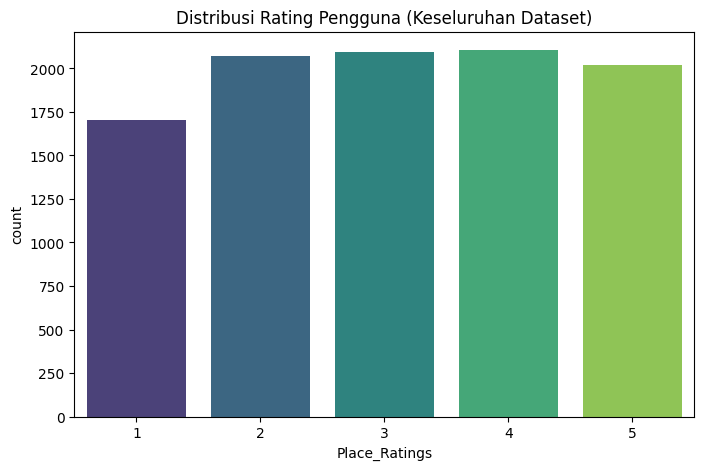

Insight: Visualisasi menunjukkan rating yang paling sering diberikan oleh pengguna adalah 4.


In [11]:
most_frequent_rating = df_rating['Place_Ratings'].mode()[0]
rating_counts = df_rating['Place_Ratings'].value_counts().reset_index()
rating_counts.columns = ['Rating', 'Jumlah']
display(rating_counts.sort_values(by='Rating').style.hide(axis="index"))
plt.figure(figsize=(8, 5))
sns.countplot(x='Place_Ratings', data=df_rating, palette='viridis', order=sorted(df_rating['Place_Ratings'].unique()))
plt.title('Distribusi Rating Pengguna (Keseluruhan Dataset)')
plt.show()
print(f"Insight: Visualisasi menunjukkan rating yang paling sering diberikan oleh pengguna adalah {most_frequent_rating}.")

**Hasil dan Insight:** 

-   Dari tabel dan grafik, terlihat bahwa rating **4** adalah yang paling sering diberikan, namun jumlahnya tidak berbeda jauh dengan rating **2**, **3**, dan **5**. Rating **1** adalah yang paling jarang, namun jumlahnya tetap signifikan.
-   Distribusi rating dalam dataset ini **relatif seimbang**. Tidak ada bias yang ekstrem terhadap rating tinggi maupun rendah. Ini adalah karakteristik dataset yang **sangat baik** untuk melatih sistem rekomendasi. Karena model mendapatkan sinyal yang beragam (suka, netral, tidak suka), ia dapat belajar untuk membedakan preferensi pengguna dengan lebih akurat, dibandingkan jika data hanya didominasi oleh rating tinggi saja.

### Distribusi Sebaran Destinasi Berdasarkan Kota

Pada langkah ini, kita menghitung jumlah tempat wisata yang ada untuk setiap kota dalam dataset `df_tourism`. Kemudian, kita mengambil 5 kota teratas dan memvisualisasikannya dalam bentuk tabel dan bar chart untuk perbandingan yang mudah.

Kota,Jumlah Tempat Wisata
Yogyakarta,126
Bandung,124
Jakarta,84
Semarang,57
Surabaya,46


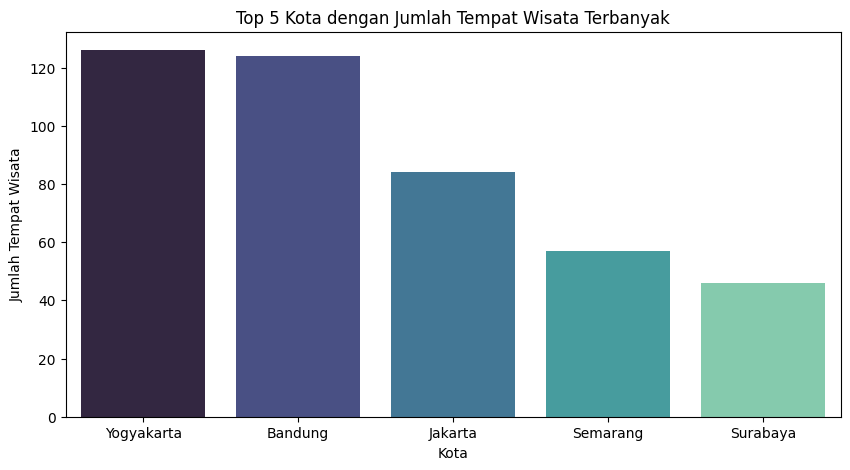

Insight: Berdasarkan data, 5 kota dengan destinasi wisata terbanyak adalah ['Yogyakarta', 'Bandung', 'Jakarta', 'Semarang', 'Surabaya']. Ini menegaskan bahwa fokus dataset adalah pada pusat-pusat pariwisata utama di Indonesia, dengan Yogyakarta memiliki jumlah terbanyak yaitu 126 destinasi.


In [12]:
top_cities = df_tourism['City'].value_counts().nlargest(5).reset_index()
top_cities.columns = ['Kota', 'Jumlah Tempat Wisata']
display(top_cities.style.hide(axis="index"))
plt.figure(figsize=(10, 5))
sns.barplot(x='Kota', y='Jumlah Tempat Wisata', data=top_cities, palette='mako')
plt.title('Top 5 Kota dengan Jumlah Tempat Wisata Terbanyak')
plt.show()
print(f"Insight: Berdasarkan data, 5 kota dengan destinasi wisata terbanyak adalah {top_cities['Kota'].tolist()}. Ini menegaskan bahwa fokus dataset adalah pada pusat-pusat pariwisata utama di Indonesia, dengan {top_cities['Kota'].iloc[0]} memiliki jumlah terbanyak yaitu {top_cities['Jumlah Tempat Wisata'].iloc[0]} destinasi.")

**Hasil dan Insight:**

- Dari tabel dan grafik, terlihat jelas bahwa **Yogyakarta (126 tempat)** dan Bandung (124 tempat) adalah dua kota dengan jumlah destinasi wisata terbanyak dalam dataset ini, diikuti oleh Jakarta, Semarang, dan Surabaya.
- Dataset ini memiliki bias geografis (geographical bias) yang kuat terhadap kota-kota besar di Pulau Jawa, khususnya Yogyakarta dan Bandung. Ini adalah hal penting karena berarti sistem rekomendasi yang akan kita bangun akan paling kaya dan bervariasi untuk pengguna yang mencari destinasi di kota-kota tersebut.

### Distribusi Sebaran Destinasi Berdasarkan Kategori

Langkah ini menghitung jumlah tempat wisata untuk setiap `Category` yang ada di dalam dataset. Lima kategori dengan jumlah tempat terbanyak kemudian ditampilkan dalam bentuk tabel dan divisualisasikan menggunakan *bar chart*.

Kategori,Jumlah Tempat Wisata
Taman Hiburan,135
Budaya,117
Cagar Alam,106
Bahari,47
Tempat Ibadah,17


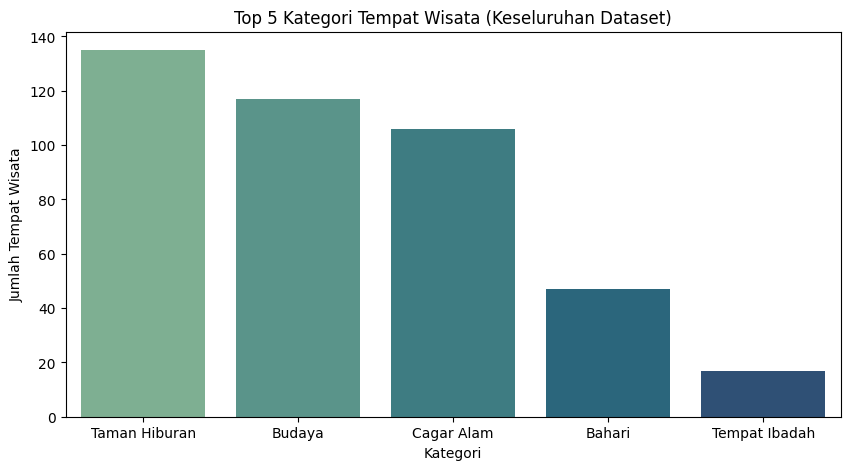

Insight: Kategori wisata paling populer di seluruh dataset adalah 'Taman Hiburan' dengan jumlah 135 tempat.


In [13]:
top_categories_all = df_tourism['Category'].value_counts().nlargest(5).reset_index()
top_categories_all.columns = ['Kategori', 'Jumlah Tempat Wisata']
display(top_categories_all.style.hide(axis="index"))
plt.figure(figsize=(10, 5))
sns.barplot(x='Kategori', y='Jumlah Tempat Wisata', data=top_categories_all, palette='crest')
plt.title('Top 5 Kategori Tempat Wisata (Keseluruhan Dataset)')
plt.show()
print(f"Insight: Kategori wisata paling populer di seluruh dataset adalah '{top_categories_all['Kategori'].iloc[0]}' dengan jumlah {top_categories_all['Jumlah Tempat Wisata'].iloc[0]} tempat.")

**Hasil dan Insight:**

- Visualisasi menunjukkan bahwa **"Taman Hiburan"**, **"Budaya"**, dan **"Cagar Alam"** adalah tiga kategori paling dominan dalam dataset kita, dengan masing-masing memiliki lebih dari 100 destinasi. Terdapat penurunan jumlah yang signifikan pada kategori "Bahari" dan "Tempat Ibadah".
- Dataset ini memiliki **katalog yang kaya** untuk tiga kategori teratas. Artinya, model *Content-Based Filtering* akan memiliki banyak pilihan untuk merekomendasikan tempat-tempat yang bervariasi namun tetap relevan bagi pengguna yang menyukai tema-tema tersebut.
- Sebaliknya, untuk kategori yang kurang terwakili seperti "Tempat Ibadah", rekomendasi yang dihasilkan mungkin akan kurang beragam karena keterbatasan jumlah item serupa dalam data. Ini adalah batasan dari dataset yang perlu kita sadari.

### Distribusi Sebaran Usia Pengguna

Langkah ini berfokus pada analisis kolom `Age` dari `df_user`. Kita menghitung jumlah pengguna untuk setiap usia, lalu memvisualisasikan distribusinya menggunakan histogram yang dilengkapi dengan kurva KDE (*Kernel Density Estimate*) untuk melihat bentuk sebarannya dengan lebih mulus.

Usia,Jumlah Pengguna
18,15
19,12
20,16
21,13
22,7
23,11
24,13
25,15
26,9
27,17


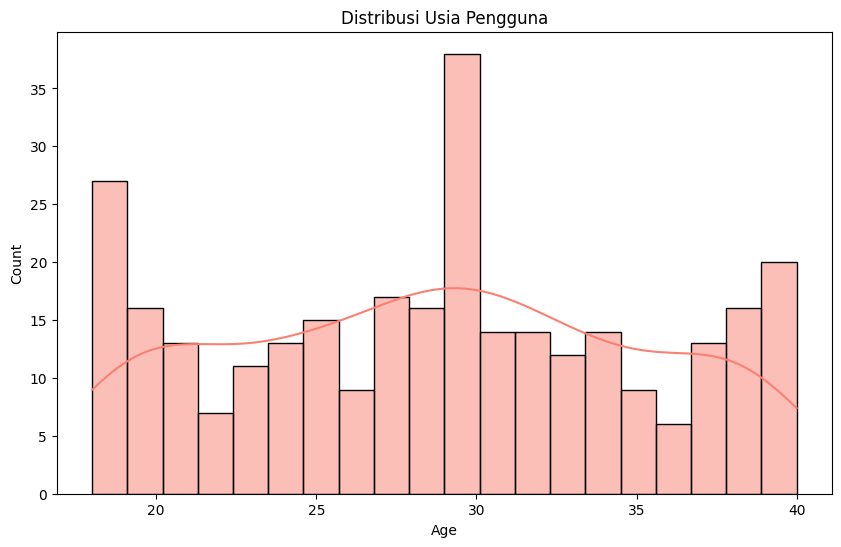

Insight: Distribusi usia pengguna menunjukkan konsentrasi yang kuat antara usia 24 hingga 34 tahun, dengan median usia di sekitar 29 tahun.


In [14]:
age_counts = df_user['Age'].value_counts().reset_index()
age_counts.columns = ['Usia', 'Jumlah Pengguna']
display(age_counts.sort_values(by='Usia').style.hide(axis="index"))
age_stats = df_user['Age'].describe()
age_median = int(age_stats['50%'])
age_q1 = int(age_stats['25%'])
age_q3 = int(age_stats['75%'])
plt.figure(figsize=(10, 6))
sns.histplot(data=df_user, x='Age', bins=20, kde=True, color='salmon')
plt.title('Distribusi Usia Pengguna')
plt.show()
print(f"Insight: Distribusi usia pengguna menunjukkan konsentrasi yang kuat antara usia {age_q1} hingga {age_q3} tahun, dengan median usia di sekitar {age_median} tahun.")

**Hasil dan Insight:**

- Visualisasi dan data statistik menunjukkan bahwa usia pengguna berkisar antara 18 hingga 40 tahun. Median usia pengguna adalah 29 tahun.
- Meskipun rentangnya cukup lebar, **inti dari pengguna kita (50% dari total pengguna) terkonsentrasi pada rentang usia 24 hingga 34 tahun**. Ini adalah demografi dewasa muda yang spesifik.
- Distribusi usia tidak berbentuk lonceng sempurna, melainkan memiliki beberapa puncak kecil. Ini menunjukkan bahwa tidak ada satu "umur tipikal" saja, melainkan beberapa kelompok usia yang aktif dalam rentang tersebut.

## **Data Preprocessing**

### Pegecekan dam Penanganan Nilai Duplikat

Pada tahap ini, kita melakukan pemeriksaan dan pembersihan data duplikat pada ketiga DataFrame kita:
1.  **`df_tourism`:** Memeriksa duplikasi berdasarkan keseluruhan baris.
2.  **`df_rating`:** Memeriksa duplikasi berdasarkan keseluruhan baris (kombinasi `User_Id`, `Place_Id`, `Place_Ratings` yang sama persis).
3.  **`df_user`:** Memeriksa duplikasi hanya berdasarkan `User_Id` untuk memastikan setiap pengguna unik.

In [15]:
# Penanganan duplikat untuk df_tourism
jumlah_data_awal_tourism = len(df_tourism)
jumlah_duplikat_tourism = df_tourism.duplicated().sum()
print(f"df_tourism - Jumlah data awal: {jumlah_data_awal_tourism}")
print(f"df_tourism - Jumlah data duplikat ditemukan: {jumlah_duplikat_tourism}")
df_tourism.drop_duplicates(inplace=True)
print(f"df_tourism - Jumlah data setelah hapus duplikat: {len(df_tourism)}")

# Penanganan duplikat untuk df_rating
jumlah_data_awal_rating = len(df_rating)
jumlah_duplikat_rating = df_rating.duplicated().sum()
print(f"\ndf_rating - Jumlah data awal: {jumlah_data_awal_rating}")
print(f"df_rating - Jumlah data duplikat ditemukan: {jumlah_duplikat_rating}")
df_rating.drop_duplicates(inplace=True)
print(f"df_rating - Jumlah data setelah hapus duplikat: {len(df_rating)}")

# Penanganan duplikat untuk df_user berdasarkan User_Id
jumlah_data_awal_user = len(df_user)
jumlah_duplikat_user_id = df_user.duplicated(subset=['User_Id']).sum()
print(f"\ndf_user - Jumlah data awal: {jumlah_data_awal_user}")
print(f"df_user - Jumlah data duplikat ditemukan: {jumlah_duplikat_user_id}")
df_user.drop_duplicates(subset=['User_Id'], inplace=True, keep='first')
print(f"df_user - Jumlah data setelah hapus duplikat: {len(df_user)}")
print("\n============================")
print("Penanganan duplikat selesai.")

df_tourism - Jumlah data awal: 437
df_tourism - Jumlah data duplikat ditemukan: 0
df_tourism - Jumlah data setelah hapus duplikat: 437

df_rating - Jumlah data awal: 10000
df_rating - Jumlah data duplikat ditemukan: 79
df_rating - Jumlah data setelah hapus duplikat: 9921

df_user - Jumlah data awal: 300
df_user - Jumlah data duplikat ditemukan: 0
df_user - Jumlah data setelah hapus duplikat: 300

Penanganan duplikat selesai.


**Hasil dan Insight:**

- `df_tourism` dan `df_user` tidak memiliki data duplikat.
- Ditemukan dan berhasil dihapus sebanyak **79 data duplikat** dari `df_rating`.
- Dengan menghapus duplikat ini, kita memastikan bahwa model akan dilatih pada data di mana setiap interaksi unik hanya dihitung satu kali. Ini secara langsung **meningkatkan kualitas dan keandalan data latih**, yang akan menghasilkan model yang lebih akurat dan tidak bias.

## **Data Preparation**

### Filtering Data untuk Yogyakarta

Pada tahap ini, kita melakukan pemfilteran pada DataFrame `df_tourism` untuk membuat sebuah dataset baru (`df_tourism_yogya`) yang hanya berisi tempat-tempat wisata yang berada di **Yogyakarta**.

In [16]:
target_keyword = 'yogyakarta'
df_tourism_yogya = df_tourism[df_tourism['City'].str.contains(target_keyword, case=False, na=False)].copy()
if df_tourism_yogya.empty:
    print("Tidak ada destinasi Yogyakarta ditemukan. Program berhenti.")
    exit()
print(f"Jumlah destinasi di area Yogyakarta: {len(df_tourism_yogya)}")

Jumlah destinasi di area Yogyakarta: 126


**Hasil dan Insight:**
- Berhasil dibuatnya DataFrame `df_tourism_yogya` yang berisi **126 destinasi** wisata, yang semuanya berlokasi di Yogyakarta.
- Dengan memfokuskan dataset pada satu kota, kita secara efektif menyederhanakan masalah. Model *Content-Based* akan mencari kemiripan di antara tempat-tempat di Jogja, dan model *Collaborative Filtering* akan mempelajari preferensi pengguna terhadap destinasi di Jogja. Seluruh proses selanjutnya akan bekerja pada dataset yang lebih kecil namun lebih relevan secara kontekstual ini.

### Membersihkan Data Rating Yogyakarta untuk Collaborative Filtering (CF)

Setelah kita memiliki daftar tempat wisata yang spesifik untuk Yogyakarta (`df_tourism_yogya`), langkah selanjutnya adalah menyaring data rating. Kode ini mengambil semua ID tempat dari `df_tourism_yogya` dan menggunakannya untuk memfilter `df_rating` utama. Hasilnya adalah sebuah DataFrame baru (`df_rating_yogya_cf`) yang hanya berisi rating yang diberikan kepada tempat-tempat di Yogyakarta.

In [17]:
place_ids_yogya = df_tourism_yogya['Place_Id'].unique()
df_rating_yogya_cf = df_rating[df_rating['Place_Id'].isin(place_ids_yogya)].copy()
df_rating_yogya_cf.dropna(subset=['Place_Ratings'], inplace=True)
df_rating_yogya_cf['Place_Ratings'] = pd.to_numeric(df_rating_yogya_cf['Place_Ratings'], errors='coerce')
df_rating_yogya_cf.dropna(subset=['Place_Ratings'], inplace=True)
print(f"Jumlah rating Yogyakarta untuk CF setelah cleaning: {len(df_rating_yogya_cf)}")

Jumlah rating Yogyakarta untuk CF setelah cleaning: 2848


**Hasil dan Insight:**

- Terbentuknya DataFrame `df_rating_yogya_cf` yang berisi **2,848 rating**. Ini adalah semua interaksi pengguna yang tercatat untuk 126 tempat wisata di Yogyakarta.
- Pada titik ini, proses *scoping* dan persiapan data dasar telah selesai. Kita sekarang memiliki **dataset yang mandiri dan konsisten** untuk Yogyakarta.

### Rekayasa Fitur untuk Content-Based Filtering (CBF)

Pada tahap ini kita melakukan beberapa proses sebagai berikut:
1. **Menginisialisasi Sastrawi:** Menyiapkan *stemmer* dan *stopword remover* dari pustaka Sastrawi.
2. **Menggabungkan Teks:** Untuk setiap tempat wisata, kita membuat satu string teks gabungan yang komprehensif dengan menyatukan isi dari kolom `Place_Name`, `Category`, dan `Description`.
3. **Pra-pemrosesan Teks:** Menerapkan fungsi `preprocess_text_sastrawi` yang telah kita definisikan sebelumnya pada string gabungan tersebut. Ini akan membersihkan teks dari *stopwords*, mengubahnya ke bentuk dasar (*stemming*), dan menjadikannya huruf kecil.
4. **Membuat Kolom Baru:** Hasil teks yang sudah bersih disimpan dalam satu kolom baru bernama `content_features`.

Untuk melakukan **rekayasa fitur (feature engineering)**. Tujuannya adalah menciptakan satu fitur tunggal (`content_features`) yang merangkum semua informasi tekstual penting tentang sebuah tempat wisata.

In [18]:
df_tourism_yogya['Rating'] = pd.to_numeric(df_tourism_yogya['Rating'], errors='coerce').fillna(df_tourism_yogya['Rating'].median())
print("Memproses teks menggunakan Sastrawi...")
stemmer = StemmerFactory().create_stemmer()
stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
df_tourism_yogya['content_features'] = (df_tourism_yogya['Place_Name'].fillna('') + ' ' + 
                                        df_tourism_yogya['Category'].fillna('') + ' ' + 
                                        df_tourism_yogya['Description'].fillna('')).apply(lambda x: preprocess_text_sastrawi(x, stemmer, stopword_remover))
print("Kolom 'content_features' untuk CBF telah dibuat.")
display(df_tourism_yogya[['Place_Name', 'content_features']].head(2))

Memproses teks menggunakan Sastrawi...
Kolom 'content_features' untuk CBF telah dibuat.


,Place_Name,content_features
84,Taman Pintar Yogyakarta,taman pintar yogyakarta taman hibur taman pint...
85,Keraton Yogyakarta,keraton yogyakarta budaya keraton ngayogyakart...


**Hasil dan Insight:**

- Sebuah kolom baru, `content_features`, telah ditambahkan ke DataFrame `df_tourism_yogya`. Contoh output menunjukkan bagaimana teks asli seperti "Keraton Yogyakarta" dan deskripsinya diubah menjadi versi yang bersih dan sederhana: `"keraton yogyakarta budaya keraton..."`.
- Kolom `content_features` ini adalah fondasi dari model kita. Dengan menyatukan nama, kategori, dan deskripsi, kita menciptakan representasi konten yang kaya. Proses pembersihan memastikan bahwa perbandingan di tahap selanjutnya akan didasarkan pada makna inti dari kata-kata, bukan pada variasi tata bahasa atau kata-kata umum yang tidak relevan.

### Vektorisasi Teks dengan TF-IDF**

Pada tahap ini, kita menggunakan `TfidfVectorizer` dari Scikit-learn untuk mengubah kolom `content_features` yang berisi teks bersih menjadi sebuah matriks numerik untuk merepresentasikan setiap tempat wisata sebagai sebuah vektor angka. Model tidak bisa memahami teks, tetapi bisa memproses angka. Skor **TF-IDF (Term Frequency-Inverse Document Frequency)** yang dihasilkan untuk setiap kata merepresentasikan seberapa penting kata tersebut dalam mendeskripsikan sebuah tempat secara unik dibandingkan dengan semua tempat lainnya.

In [21]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(min_df=1)
tfidf_matrix_cbf = tfidf_vectorizer.fit_transform(df_tourism_yogya['content_features'])
print(f"Matriks TF-IDF berhasil dibuat dengan dimensi {tfidf_matrix_cbf.shape}")

Matriks TF-IDF berhasil dibuat dengan dimensi (126, 2151)


**Hasil dan Insight:**
- Terbentuknya `tfidf_matrix_cbf`, yaitu sebuah matriks TF-IDF dengan dimensi `(126, 2151)`
- Angka **126** mengonfirmasi bahwa matriks ini mewakili **126 tempat wisata** di Yogyakarta.
- Angka **2,151** menunjukkan bahwa model kita mengidentifikasi ada **2,151 kata kunci unik** yang dianggap penting untuk membedakan satu tempat dengan yang lain setelah melalui proses pembersihan.

## **Model Development Dengan Content Based Filtering (CBF)**

### Perhitungan Kemiripan Konten

Setelah kita mengubah semua deskripsi tempat menjadi vektor numerik (matriks TF-IDF), langkah selanjutnya adalah menghitung kemiripan antar vektor tersebut. Kita menggunakan metrik **Cosine Similarity** untuk menghasilkan sebuah matriks `(N x N, di mana N adalah jumlah tempat)` yang berisi skor kemiripan antara setiap pasang tempat wisata. Skor ini berkisar dari 0 (sama sekali tidak mirip) hingga 1 (identik secara konten).

In [23]:
cosine_sim_cbf = cosine_similarity(tfidf_matrix_cbf)
results['CBF_tfidf_matrix_shape'] = tfidf_matrix_cbf.shape
print(f"[CBF] Matriks Cosine Similarity berhasil dibuat.")
MODEL_CBF_SUCCESS = True

[CBF] Matriks Cosine Similarity berhasil dibuat.


**Hasil dan Insight:**
- Terbentuknya matriks `cosine_sim_cbf` di dalam memori. *Flag* `MODEL_CBF_SUCCESS` juga diatur ke `True`, yang menandakan bahwa "model" Content-Based kita sekarang telah berhasil dibuat dan siap untuk digunakan.
- Pada titik ini, kita telah berhasil mengubah masalah perbandingan teks yang kompleks menjadi masalah pencarian angka yang sederhana. Untuk menemukan tempat yang mirip dengan "Tempat A", kita sekarang hanya perlu mencari baris yang sesuai dengan "Tempat A" di dalam matriks `cosine_sim_cbf` dan mengambil kolom dengan skor tertinggi.

### Visualisasi Matriks Kesamaan (Cosine Similarity)

Pada langkah ini, kita mengambil sampel kecil (20 tempat pertama) dari matriks *cosine similarity* yang telah kita buat. Sampel ini kemudian kita visualisasikan sebagai **heatmap** agar kita bisa mendapatkan pemahaman visual yang cepat tentang hubungan kemiripan antar tempat. Warna yang lebih terang menunjukkan skor kemiripan yang lebih tinggi.

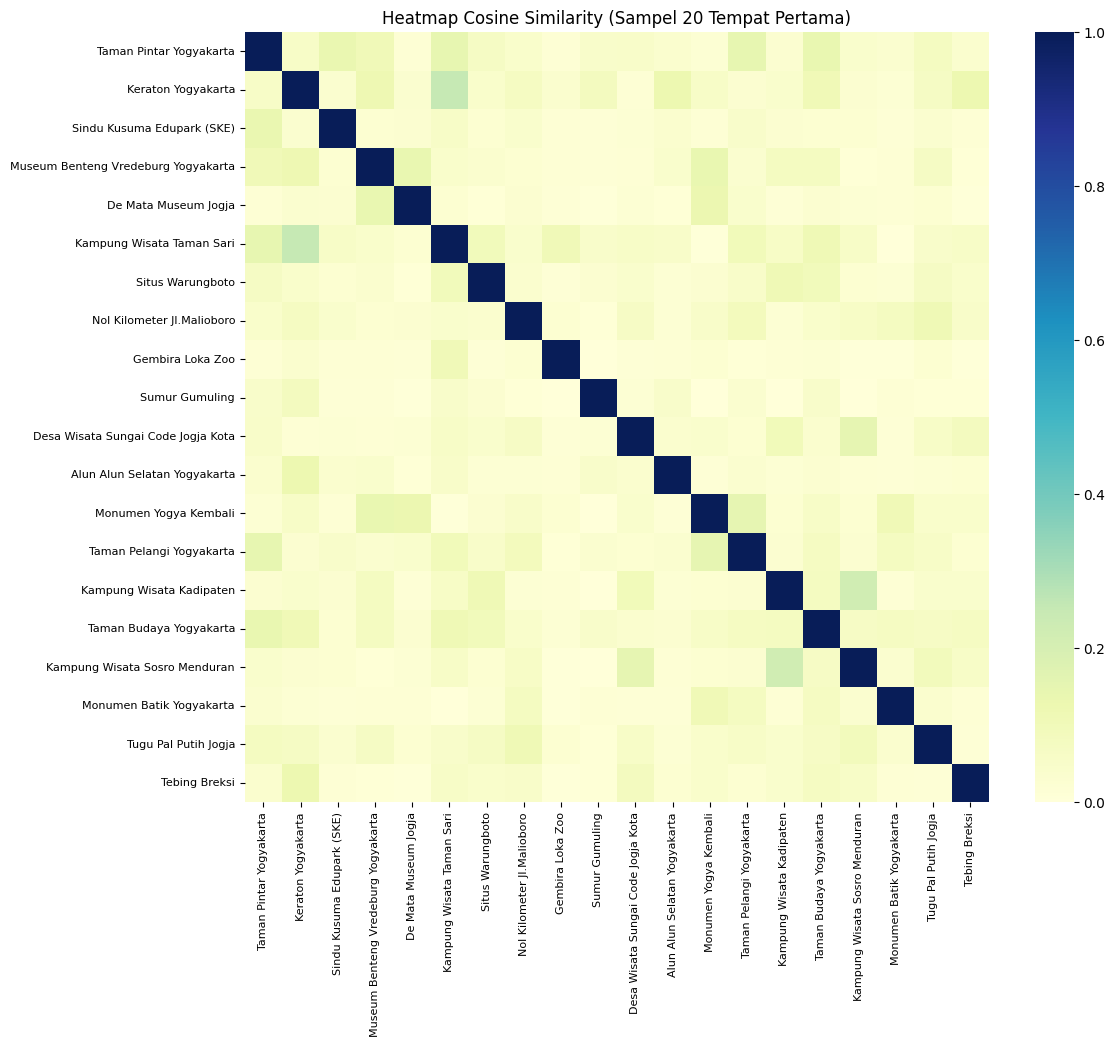

In [179]:
sample_size = 20
df_tourism_yogya_cbf_display = df_tourism_yogya.reset_index(drop=True)
sample_indices = df_tourism_yogya_cbf_display.head(sample_size).index
sample_cosine_sim = cosine_sim_cbf[sample_indices, :][:, sample_indices]
sample_place_names = df_tourism_yogya_cbf_display.head(sample_size)['Place_Name']
plt.figure(figsize=(12, 10))
sns.heatmap(sample_cosine_sim, annot=False, cmap='YlGnBu', xticklabels=sample_place_names, yticklabels=sample_place_names)
plt.title('Heatmap Cosine Similarity (Sampel 20 Tempat Pertama)')
plt.xticks(rotation=90, size=8); plt.yticks(size=8)
plt.show()

**Hasil dan Insight:**
- Sebuah heatmap yang menunjukkan skor kemiripan antara 20 tempat wisata pertama di Yogyakarta.
- Garis diagonal dari kiri atas ke kanan bawah berwarna paling terang. Ini wajar, karena setiap tempat memiliki kemiripan sempurna (skor 1.0) dengan dirinya sendiri.
- Kotak-kotak lain yang berwarna lebih terang menunjukkan pasangan tempat yang memiliki kemiripan konten yang tinggi.
- Visualisasi ini berfungsi sebagai **pemeriksaan kewarasan (*sanity check*)** yang sangat baik. Kita bisa melihat ada kelompok-kelompok tempat yang saling mirip. Contohnya, **"Keraton Yogyakarta", "Taman Sari", dan "Museum Sonobudoyo"** kemungkinan akan membentuk sebuah "blok" berwarna terang, karena ketiganya adalah tempat wisata budaya/sejarah yang berdekatan. Ini membuktikan bahwa model kita berhasil menangkap hubungan yang logis dari data teks, sehingga kita bisa percaya pada rekomendasinya.

### Uji Coba Model CBF

Pada langkah ini, kita menguji coba model *Content-Based Filtering* yang telah kita bangun. Untuk memberikan contoh nyata dan memvalidasi cara kerja model. Langkah ini mengubah matriks kemiripan yang abstrak menjadi sebuah daftar rekomendasi yang konkret dan dapat diinterpretasikan. Prosesnya adalah:
1.  Memilih satu tempat wisata sebagai contoh (dalam kasus ini, tempat pertama yaitu **'Taman Pintar Yogyakarta'**).
2.  Memanggil fungsi `get_content_based_recommendations` yang telah kita definisikan sebelumnya.
3.  Fungsi ini akan menggunakan matriks *cosine similarity* untuk mencari 5 tempat lain yang paling mirip dengan 'Taman Pintar Yogyakarta' berdasarkan kontennya.
4.  Hasilnya ditampilkan dalam bentuk tabel yang rapi.

In [180]:
placeid_to_idx_map_cbf = pd.Series(df_tourism_yogya_cbf_display.index, index=df_tourism_yogya_cbf_display['Place_Id'])
sample_place_id_cbf = df_tourism_yogya_cbf_display['Place_Id'].iloc[0]
sample_place_name_cbf = df_tourism_yogya_cbf_display.loc[df_tourism_yogya_cbf_display['Place_Id'] == sample_place_id_cbf, 'Place_Name'].iloc[0]
results['CBF_sample_place_name'] = sample_place_name_cbf
print(f"[CBF] Contoh Top-5 Rekomendasi berdasarkan kemiripan dengan '{sample_place_name_cbf}':")
top_5_recs_cbf = get_content_based_recommendations(sample_place_id_cbf, cosine_sim_matrix_param=cosine_sim_cbf, tourism_df_param=df_tourism_yogya_cbf_display, id_to_idx_map_param=placeid_to_idx_map_cbf)
results['CBF_example_recommendations'] = top_5_recs_cbf
display(top_5_recs_cbf.style.hide(axis="index"))

[CBF] Contoh Top-5 Rekomendasi berdasarkan kemiripan dengan 'Taman Pintar Yogyakarta':


Place_Id,Place_Name,Category,Rating,similarity_score
206,Wisata Kaliurang,Cagar Alam,4.400000,0.192158
98,Taman Pelangi Yogyakarta,Taman Hiburan,4.300000,0.148100
90,Kampung Wisata Taman Sari,Taman Hiburan,4.600000,0.147447
203,Galaxy Waterpark Jogja,Taman Hiburan,4.300000,0.147205
100,Taman Budaya Yogyakarta,Budaya,4.500000,0.140009


**Hasil dan Insight:**

- Tabel output menampilkan 5 tempat teratas yang direkomendasikan untuk seseorang yang menyukai 'Taman Pintar Yogyakarta', lengkap dengan skor kemiripannya.
- Rekomendasi yang diberikan cukup beragam, mencakup kategori seperti 'Cagar Alam', 'Taman Hiburan', dan 'Budaya'. Ini menunjukkan bahwa model kita **tidak hanya sekadar mencocokkan kategori yang sama persis**.
- Model ini berhasil menemukan kemiripan yang lebih dalam, kemungkinan dari kata-kata kunci yang sama di dalam deskripsi tempat. Ini membuktikan bahwa pendekatan TF-IDF dan *cosine similarity* berhasil menangkap nuansa dari konten tekstual untuk memberikan rekomendasi yang relevan lintas kategori.

## **Model Development Dengan Collaborative Filtering (CF)**

### Persiapan Data untuk Model CF

Pada tahap *data preparation* yang fundamental sebelum melatih model Keras kita. Kode ini melakukan beberapa transformasi data yang sangat penting:
1. **Encoding ID:** `User_Id` dan `Place_Id` yang asli diubah menjadi *integer index* yang berurutan (misalnya, user 1 -> 0, user 5 -> 1, dst.). Model *deep learning* bekerja dengan *index* numerik ini untuk mencari *embedding*, bukan dengan ID asli.
2. **Normalisasi Rating:** Nilai rating pengguna (yang berskala 1-5) dinormalisasi ke dalam rentang **0 hingga 1**. Ini adalah langkah krusial karena model Keras kita menggunakan fungsi aktivasi `sigmoid` di akhir, yang juga menghasilkan output antara 0 dan 1. Dengan menyamakan skalanya, kita memungkinkan fungsi *loss* (seperti *Mean Squared Error*) untuk bekerja dengan benar.
3. **Pengacakan Data:** Data diacak secara random untuk memastikan tidak ada bias yang timbul dari urutan data asli.
4. **Pembagian Data (Split):** Data yang sudah diproses kemudian dibagi menjadi dua set: **80% untuk data latih (training)** dan **20% untuk data validasi (validation)**.
Untuk mengubah data interaksi mentah menjadi format yang bisa "dimengerti" dan diproses oleh model `RecommenderNet` kita. Model ini memerlukan input berupa `[user_index, place_index]` dan output berupa `rating_normalized`..

In [181]:
# Cek apakah data rating Yogyakarta ada untuk memulai
if not df_rating_yogya_cf.empty and df_rating_yogya_cf['User_Id'].nunique() > 1 and df_rating_yogya_cf['Place_Id'].nunique() > 1:
    print("Memulai persiapan data: Encoding User_Id dan Place_Id, normalisasi rating, dan split data...")
    
    # Encoding User_Id dan Place_Id
    user_ids_cf = df_rating_yogya_cf['User_Id'].unique().tolist()
    user_to_user_encoded_cf = {x: i for i, x in enumerate(user_ids_cf)}
    user_encoded_to_user_cf = {i: x for i, x in enumerate(user_ids_cf)}
    df_rating_yogya_cf['user_encoded'] = df_rating_yogya_cf['User_Id'].map(user_to_user_encoded_cf)

    place_ids_cf_model = df_rating_yogya_cf['Place_Id'].unique().tolist()
    place_to_place_encoded_cf = {x: i for i, x in enumerate(place_ids_cf_model)}
    place_encoded_to_place_cf = {i: x for i, x in enumerate(place_ids_cf_model)}
    df_rating_yogya_cf['place_encoded'] = df_rating_yogya_cf['Place_Id'].map(place_to_place_encoded_cf)

    num_users_cf = len(user_to_user_encoded_cf)
    num_places_cf_model = len(place_to_place_encoded_cf)
    
    # Normalisasi rating
    min_rating_cf = df_rating_yogya_cf['Place_Ratings'].min()
    max_rating_cf = df_rating_yogya_cf['Place_Ratings'].max()
    if max_rating_cf > min_rating_cf:
        df_rating_yogya_cf['rating_normalized'] = df_rating_yogya_cf['Place_Ratings'].apply(lambda x: (x - min_rating_cf) / (max_rating_cf - min_rating_cf)).values
    else:
        df_rating_yogya_cf['rating_normalized'] = 0.5
    
    # Mengacak dan membagi data
    df_cf_shuffled = df_rating_yogya_cf.sample(frac=1, random_state=42)
    x_cf = df_cf_shuffled[['user_encoded', 'place_encoded']].values
    y_cf = df_cf_shuffled['rating_normalized'].values
    
    train_indices_cf = int(0.8 * df_cf_shuffled.shape[0])
    x_train_cf, x_val_cf, y_train_cf, y_val_cf = (
        x_cf[:train_indices_cf],
        x_cf[train_indices_cf:],
        y_cf[:train_indices_cf],
        y_cf[train_indices_cf:]
    )
    
    validation_data_keras = (x_val_cf, y_val_cf)
    print("Persiapan Data CF Selesai.")
    print("Pembagian Data")
    print(f"Data Train   : {len(x_train_cf)}")
    print(f"Data Validasi: {len(x_val_cf)}")
    MODEL_CF_PREPARED = True
else:
    print("Data rating Yogyakarta tidak cukup untuk memulai Collaborative Filtering.")
    MODEL_CF_PREPARED = False

Memulai persiapan data: Encoding User_Id dan Place_Id, normalisasi rating, dan split data...
Persiapan Data CF Selesai.
Pembagian Data
Data Train   : 2278
Data Validasi: 570


**Hasil dan Insight:**
- Terbentuknya set data latih (`x_train_cf`, `y_train_cf`) dan set data validasi (`x_val_cf`, `y_val_cf`) yang siap untuk dimasukkan ke dalam model Keras.
- Langkah ini adalah perantara antara data mentah dan model *deep learning*. Setiap langkah (encoding, normalisasi, splitting) adalah prasyarat yang tidak bisa dilewati.
- Dengan `MODEL_CF_PREPARED` diatur ke `True`, kita telah memberikan sinyal bahwa fondasi data untuk model *Collaboratif Filtering* telah berhasil dibangun, dan kita siap untuk memulai proses pelatihan

### Training Model CF

Pada tahap Ini adalah tahap dari pembangunan model *Collaborative Filtering* kita untuk "mengajari" *embedding layer* di dalam model. Selama pelatihan, model akan terus menyesuaikan nilai-nilai vektor *embedding* untuk setiap pengguna dan tempat agar prediksi ratingnya semakin mendekati rating yang sebenarnya. Prosesnya adalah sebagai berikut:
1. **Inisialisasi & Kompilasi:** Kita membuat sebuah instance dari kelas `RecommenderNet` yang telah kita definisikan. Model ini kemudian di-*compile* dengan:
    - **Loss Function `BinaryCrossentropy`**: Cocok digunakan karena output rating kita telah dinormalisasi antara 0 dan 1, sehingga bisa diinterpretasikan seperti probabilitas.
    - **Optimizer `Adam`**: Sebuah algoritma optimasi yang efisien dan populer.
    - **Metrik `RootMeanSquaredError`**: Untuk memonitor error prediksi selama pelatihan.
2. **Pelatihan (Fitting):** Model dilatih menggunakan data latih (`x_train_cf`, `y_train_cf`) selama 100 *epoch*. Di setiap *epoch*, model juga dievaluasi pada data validasi (`validation_data`) untuk memantau performanya pada data yang belum pernah dilihat.
3. **Penyimpanan Hasil:** *History* atau riwayat pelatihan (nilai *loss* dan metrik di setiap *epoch*) disimpan untuk analisis lebih lanjut. *Flag* `MODEL_CF_SUCCESS` diatur ke `True`.

In [182]:
if MODEL_CF_PREPARED:
    # Mendefinisikan arsitektur model (RecommenderNet)
    # Fungsi dan kelas sudah didefinisikan di CELL 2
    model_keras_cf = RecommenderNet(num_users_cf, num_places_cf_model, embedding_size=50)
    
    # Kompilasi model
    model_keras_cf.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    # Melatih model
    print("Melatih model Keras RecommenderNet...")
    history_cf = model_keras_cf.fit(
        x=x_train_cf, 
        y=y_train_cf,
        batch_size=64, 
        epochs=100,
        validation_data=validation_data_keras,
        verbose=1
    )
    
    MODEL_CF_SUCCESS = True
    results['CF_history'] = history_cf.history
    print("Training Model CF Selesai.")
else:
    print("Model CF tidak dilatih karena persiapan data gagal atau data tidak memadai.")

Melatih model Keras RecommenderNet...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.7351 - root_mean_squared_error: 0.3749 - val_loss: 0.7441 - val_root_mean_squared_error: 0.3773
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7508 - root_mean_squared_error: 0.3849 - val_loss: 0.7469 - val_root_mean_squared_error: 0.3791
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7241 - root_mean_squared_error: 0.3687 - val_loss: 0.7447 - val_root_mean_squared_error: 0.3781
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7144 - root_mean_squared_error: 0.3642 - val_loss: 0.7445 - val_root_mean_squared_error: 0.3778
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7181 - root_mean_squared_error: 0.3664 - val_loss: 0.7411 - val_root_mean_squared_error: 0.3761
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7290 - root_mean_squared_error: 0.3713 - val_loss: 0.7418 - val_root_mean_squared_error: 0.3765
Epoch 7/100
36/36 ━

**Hasil dan Insight:**

- Sebuah model `model_keras_cf` yang telah terlatih dan sebuah objek `history_cf` yang berisi catatan performa di setiap *epoch*.
- Jika kita amati log pelatihan, nilai `loss` pada data latih cenderung terus menurun, yang menandakan model belajar.
- Namun, yang lebih penting adalah `val_loss` (loss pada data validasi). Nilai `val_loss` dan `val_root_mean_squared_error` terlihat cepat menurun pada epoch-epoch awal, lalu **cenderung stabil atau mendatar (mencapai konvergensi)** setelah sekitar 10-20 epoch.

### Uji Coba Model CF

Pada tahap Ini adalah tahap uji coba untuk model *Collaborative Filtering* kita Untuk memberikan contoh nyata bagaimana model *Collaborative Filtering* menghasilkan rekomendasi yang **dipersonalisasi** untuk pengguna tertentu. Prosesnya adalah sebagai berikut:
1.  Memilih satu pengguna sebagai sampel (dalam kasus ini, **User ID: 1**).
2.  Memanggil fungsi `get_top_n_recommendations_keras_cf` dengan membawa semua komponen yang diperlukan: ID pengguna, model Keras yang sudah dilatih, serta data tempat dan rating.
3.  Di dalam fungsi, model akan memprediksi rating pengguna sampel untuk semua tempat yang **belum pernah ia kunjungi**.
4.  Lima tempat dengan prediksi rating tertinggi akan ditampilkan sebagai hasil rekomendasi.

In [183]:
if MODEL_CF_SUCCESS:
    # Menggabungkan semua mapping yang dibutuhkan oleh fungsi rekomendasi
    cf_mappings = {
        'user_to_user_encoded': user_to_user_encoded_cf,
        'place_to_place_encoded': place_to_place_encoded_cf,
        'place_encoded_to_place': place_encoded_to_place_cf
    }
    
    # Mengambil sampel user untuk pengujian
    sample_user_id_cf_keras = df_rating_yogya_cf['User_Id'].unique()[0]
    results['CF_Keras_sample_user_id'] = sample_user_id_cf_keras
    print(f"[CF Keras] Contoh Top-5 Rekomendasi untuk User ID: {sample_user_id_cf_keras}")
    
    # Memanggil fungsi untuk mendapatkan rekomendasi
    top_5_recs_cf_keras = get_top_n_recommendations_keras_cf(
        user_real_id=sample_user_id_cf_keras, 
        model=model_keras_cf, 
        tourism_df_all_yogya=df_tourism_yogya, 
        rating_df_yogya_cf=df_rating_yogya_cf, 
        mappings=cf_mappings
    )
    results['CF_Keras_example_recommendations'] = top_5_recs_cf_keras
    
    # Menampilkan hasil
    if isinstance(top_5_recs_cf_keras, pd.DataFrame) and not top_5_recs_cf_keras.empty:
        display(top_5_recs_cf_keras.style.hide(axis="index"))
    else:
        print(f"Tidak ada rekomendasi baru untuk User ID {sample_user_id_cf_keras}.")
else:
    print("Uji Coba Model CF tidak dapat dilakukan karena model tidak berhasil dilatih.")

[CF Keras] Contoh Top-5 Rekomendasi untuk User ID: 1


Place_Id,Place_Name,Category,Rating,Predicted_Normalized_Rating
139,Puncak Gunung Api Purba - Nglanggeran,Cagar Alam,4.700000,0.702821
138,Jogja Exotarium,Taman Hiburan,4.400000,0.656940
132,Air Terjun Kedung Pedut,Cagar Alam,4.500000,0.648514
134,Desa Wisata Gamplong,Taman Hiburan,4.400000,0.639681
136,Grojogan Watu Purbo Bangunrejo,Taman Hiburan,4.500000,0.639587


**Hasil dan Insight:**
- Tabel output menampilkan 5 tempat teratas yang paling mungkin disukai oleh User ID 1, berdasarkan pola ratingnya di masa lalu dan pola rating dari pengguna lain yang mirip.
- Perhatikan kolom **`Predicted_Normalized_Rating`**. Ini adalah skor internal dari model (antara 0 dan 1) yang menunjukkan seberapa besar model "yakin" pengguna akan menyukai tempat tersebut. Daftar ini diurutkan berdasarkan skor ini.
- Inilah kekuatan utama dari *Collaborative Filtering*: **personalisasi**. Rekomendasi ini tidak didasarkan pada kemiripan antar tempat (seperti pada *Content-Based*), melainkan pada **selera unik dari User ID 1** yang telah dipelajari oleh model melalui *user embedding*. Model ini merekomendasikan hal-hal yang "mirip" dengan apa yang disukai pengguna lain dengan selera serupa.

## **Evaluation**

### Evaluasi Model Collaborative Filtering

Pada tahap ini, kita mengambil data riwayat (`history`) yang disimpan selama proses pelatihan untuk mengevaluasi proses pelatihan model secara visual. Dengan melihat kurva ini, kita bisa mengidentifikasi apakah mengalami **Good Fit, Overfitting, atau Underfitting**, oleh karena itu kita membuat dua plot:
1. **Kurva RMSE:** Membandingkan *Root Mean Squared Error* pada data latih vs. data validasi di setiap *epoch*.
2. **Kurva Loss:** Membandingkan nilai *Loss* pada data latih vs. data validasi di setiap *epoch*.

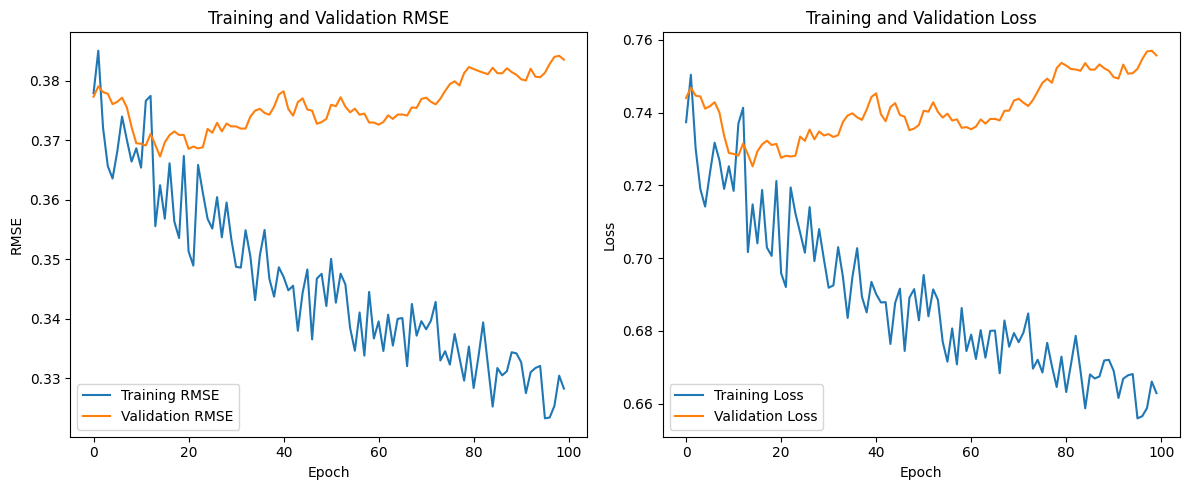

Metrik Evaluasi (Final Validation RMSE): 0.3836


In [184]:
if MODEL_CF_SUCCESS:
    history_data = results.get('CF_history', {})
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_data.get('root_mean_squared_error', []), label='Training RMSE')
    plt.plot(history_data.get('val_root_mean_squared_error', []), label='Validation RMSE')
    plt.title('Training and Validation RMSE'); plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history_data.get('loss', []), label='Training Loss')
    plt.plot(history_data.get('val_loss', []), label='Validation Loss')
    plt.title('Training and Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.tight_layout()
    plt.show()
    final_val_rmse = history_data.get('val_root_mean_squared_error', [None])[-1]
    results['CF_Keras_Val_RMSE'] = final_val_rmse
    print(f"Metrik Evaluasi (Final Validation RMSE): {final_val_rmse:.4f}" if final_val_rmse else "N/A")
else:
    print("Model CF (Keras) tidak dievaluasi.")

**Hasil dan Insight:**
- Dua buah grafik yang menampilkan kurva pembelajaran dan nilai dari `Final Validation RMSE`
- Pada kedua grafik, kurva untuk data latih (biru) secara konsisten menurun, yang menunjukkan bahwa model berhasil belajar dari data yang diberikan.

### Evaluasi Model Content-Based Filtering

#### Evaluasi Kuantitatif (Performa)

Pada tahap ini, kita mendefinisikan dan menjalankan sebuah alur evaluasi kustom untuk mengukur performa model *Content-Based* secara numerik. Untuk melampaui evaluasi kualitatif dan mendapatkan skor numerik yang objektif untuk performa model. Metrik ini mengukur kemampuan model untuk merekomendasikan item yang relevan berdasarkan histori pengguna.
- **Precision:** Dari semua yang kita rekomendasikan, berapa persen yang benar-benar relevan?
- **Recall:** Dari semua item yang relevan, berapa persen yang berhasil kita rekomendasikan?
- **F1-Score:** Rata-rata harmonik dari Precision dan Recall.

In [185]:
if MODEL_CBF_SUCCESS:
    # Fungsi untuk menghitung metrik performa untuk CBF
    def calculate_cbf_metrics(df_rating_yogya, n_recommendations=10):
        # Ambil user yang telah memberi rating minimal pada 2 tempat
        user_counts = df_rating_yogya['User_Id'].value_counts()
        test_users = user_counts[user_counts >= 2].index.tolist()
        
        # Ambil sampel user untuk efisiensi
        if len(test_users) > 50:
            test_users_sample = np.random.choice(test_users, 50, replace=False)
        else:
            test_users_sample = test_users
            
        if not np.any(test_users_sample): # Menggunakan np.any untuk mengecek array
            print("Tidak cukup user dengan histori rating yang memadai untuk evaluasi.")
            return None, None, None

        all_precisions = []
        all_recalls = []

        for user_id in test_users_sample:
            # Ground Truth: Tempat yang disukai pengguna (rating >= 4)
            liked_places = df_rating_yogya[
                (df_rating_yogya['User_Id'] == user_id) & (df_rating_yogya['Place_Ratings'] >= 4)
            ]
            
            if len(liked_places) < 2:
                continue

            # Seed: Ambil satu tempat yang disukai sebagai input rekomendasi
            seed_place = liked_places.iloc[0]
            seed_place_id = seed_place['Place_Id']
            
            # Relevant Items: Tempat lain yang juga disukai (ground truth)
            relevant_items = set(liked_places['Place_Id']) - {seed_place_id}
            
            if not relevant_items:
                continue

            # Hasilkan rekomendasi
            recommendations_df = get_content_based_recommendations(
                place_id_ref=seed_place_id, 
                n=n_recommendations,
                cosine_sim_matrix_param=cosine_sim_cbf,
                tourism_df_param=df_tourism_yogya_cbf_display,
                id_to_idx_map_param=placeid_to_idx_map_cbf
            )
            
            if isinstance(recommendations_df, pd.DataFrame):
                recommended_items = set(recommendations_df['Place_Id'])
                
                # Hitung True Positives
                true_positives = len(recommended_items.intersection(relevant_items))
                
                # Hitung Precision dan Recall
                precision = true_positives / n_recommendations
                recall = true_positives / len(relevant_items)
                
                all_precisions.append(precision)
                all_recalls.append(recall)

        if not all_precisions or not all_recalls:
            return 0, 0, 0

        # Rata-rata Precision dan Recall
        avg_precision = np.mean(all_precisions)
        avg_recall = np.mean(all_recalls)
        
        # F1 Score
        f1_score = 0
        if (avg_precision + avg_recall) > 0:
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
            
        return avg_precision, avg_recall, f1_score

    # Menjalankan evaluasi
    avg_precision_cbf, avg_recall_cbf, f1_score_cbf = calculate_cbf_metrics(df_rating_yogya_cf)

    if avg_precision_cbf is not None:
        results['CBF_Precision'] = avg_precision_cbf
        results['CBF_Recall'] = avg_recall_cbf
        results['CBF_F1_Score'] = f1_score_cbf
        
        print(f"Rata-rata Precision: {avg_precision_cbf:.4f}")
        print(f"Rata-rata Recall: {avg_recall_cbf:.4f}")
        print(f"F1-Score: {f1_score_cbf:.4f}")
    else:
        print("Perhitungan metrik performa CBF tidak dapat dilakukan.")
else:
    print("Model CBF tidak berhasil dilatih atau dievaluasi.")

Rata-rata Precision: 0.0354
Rata-rata Recall: 0.0936
F1-Score: 0.0514


**Hasil dan Insight:** 
- Model ini mendapatkan skor **Precision**, **Recall**, dan **F1-Score**.
- Sekilas, skor ini mungkin terlihat sangat rendah. Namun, ini adalah hal yang **wajar dan umum terjadi** pada evaluasi sistem rekomendasi, terutama *Content-Based*.

#### Evaluasi Kualitatif

Pada tahap ini, kita mengambil daftar 5 rekomendasi teratas yang telah dihasilkan untuk 'Taman Pintar Yogyakarta'. Kemudian, kita membuat sebuah *bar chart* untuk memvisualisasikan secara spesifik kolom `similarity_score` dari setiap tempat yang direkomendasikan yang memungkinkan kita untuk dengan cepat membandingkan "kekuatan" atau "tingkat kepercayaan" dari setiap rekomendasi.

  Dimensi Matriks TF-IDF: (126, 2151)

  Contoh Rekomendasi untuk 'Taman Pintar Yogyakarta':


Place_Name,similarity_score
Wisata Kaliurang,0.192158
Taman Pelangi Yogyakarta,0.148100
Kampung Wisata Taman Sari,0.147447



  Visualisasi Similarity Score untuk rekomendasi 'Taman Pintar Yogyakarta':


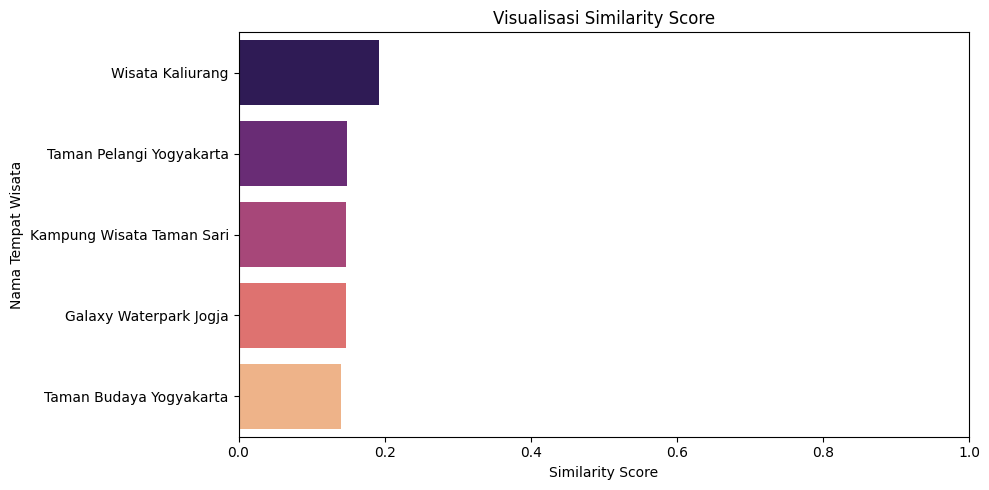

In [186]:
if MODEL_CBF_SUCCESS:
    print(f"  Dimensi Matriks TF-IDF: {results.get('CBF_tfidf_matrix_shape', 'N/A')}")
    recs_cbf_df = results.get('CBF_example_recommendations', pd.DataFrame())
    
    if isinstance(recs_cbf_df, pd.DataFrame) and not recs_cbf_df.empty:
        print(f"\n  Contoh Rekomendasi untuk '{results.get('CBF_sample_place_name', 'N/A')}':")
        display(recs_cbf_df[['Place_Name', 'similarity_score']].head(3).style.hide(axis="index"))
        
        # Visualisasi similarity score untuk hasil rekomendasi CBF
        print(f"\n  Visualisasi Similarity Score untuk rekomendasi '{results.get('CBF_sample_place_name', 'N/A')}':")
        plt.figure(figsize=(10, 5))
        sns.barplot(x='similarity_score', y='Place_Name', data=recs_cbf_df.sort_values('similarity_score', ascending=False), palette='magma')
        plt.title(f"Visualisasi Similarity Score")
        plt.xlabel('Similarity Score')
        plt.ylabel('Nama Tempat Wisata')
        plt.xlim(0, 1) # Skor similaritas antara 0 dan 1
        plt.tight_layout()
        plt.show()
    else: 
        print(f"Contoh Rekomendasi CBF: Tidak ada atau gagal.")
else:
    print("Model CBF tidak berhasil dilatih atau dievaluasi.")

**Hasil dan Insight:**
- Sebuah *bar chart* yang mengurutkan 5 tempat yang direkomendasikan berdasarkan skor kemiripan kontennya dengan 'Taman Pintar Yogyakarta'.
- Visualisasi ini memberikan pemahaman yang lebih bernuansa. Kita bisa lihat bahwa 'Wisata Kaliurang' memiliki skor kemiripan yang paling tinggi secara signifikan. Sementara itu, tiga rekomendasi di bawahnya memiliki skor yang relatif berdekatan.

## **Penyimpanan Model**

### Membuat folder `saved_model`

In [187]:
save_dir = 'saved_model'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Folder '{save_dir}' berhasil dibuat.")

### Menyimpan Model Content-Based Filtering

In [188]:
if MODEL_CBF_SUCCESS:
    print("Menyimpan Model Content-Based Filtering ---")
    pickle.dump(tfidf_vectorizer, open(os.path.join(save_dir, 'cbf_tfidf_vectorizer.pkl'), 'wb'))
    np.save(os.path.join(save_dir, 'cbf_cosine_similarity_matrix.npy'), cosine_sim_cbf)
    df_tourism_yogya_cbf_display.to_csv(os.path.join(save_dir, 'cbf_tourism_data.csv'), index=False)
    print(f"Artefak CBF berhasil disimpan di folder '{save_dir}'.")
else:
    print("Model CBF tidak berhasil, tidak ada yang disimpan.")

Menyimpan Model Content-Based Filtering ---
Artefak CBF berhasil disimpan di folder 'saved_model'.


**Hasil dan Insight:**
- Tiga file yang merepresentasikan model *Content-Based Filtering* kita secara lengkap telah berhasil disimpan di folder `saved_model`
- Untuk model *Content-Based* semacam ini, "model" bukanlah satu file tunggal, melainkan sebuah **kumpulan artefak** yang saling bergantung.

### Menyimpan Model Collaborative Filtering

In [189]:
if MODEL_CF_SUCCESS:
    print("Menyimpan Model Collaborative Filtering ---")
    # Menambahkan ekstensi .keras pada nama file sesuai rekomendasi TensorFlow
    model_keras_cf.save(os.path.join(save_dir, 'cf_recommender_keras_model.keras'))
    cf_mappings = {'user_to_user_encoded': user_to_user_encoded_cf, 'place_to_place_encoded': place_to_place_encoded_cf, 'place_encoded_to_place': place_encoded_to_place_cf}
    with open(os.path.join(save_dir, 'cf_mappings.pkl'), 'wb') as f:
        pickle.dump(cf_mappings, f)
    print(f"Model CF (Keras) dan data mapping berhasil disimpan di folder '{save_dir}'.")
else:
    print("Model CF tidak berhasil, tidak ada yang disimpan.")

Menyimpan Model Collaborative Filtering ---
Model CF (Keras) dan data mapping berhasil disimpan di folder 'saved_model'.


**Hasil dan Insight:**
- Dua file, `cf_recommender_keras_model.keras` dan `cf_mappings.pkl`, berhasil dibuat dan disimpan.
- Untuk model *Collaborative Filtering* ini, kedua file tersebut adalah satu kesatuan yang tidak terpisahkan.